In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from skimage.transform import resize
import h5py
import os
import cv2


### Resize as 42x42(Camera like), make it between 0 and 127(Divide each pixel by 2), so that it can be represented in 7 bits

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Resize images to 42x42 using OpenCV
x_train_resized = np.zeros((x_train.shape[0], 42, 42), dtype=np.uint8)
for i in range(x_train.shape[0]):
    x_train_resized[i] = cv2.resize(x_train[i], (42, 42))

x_test_resized = np.zeros((x_test.shape[0], 42, 42), dtype=np.uint8)
for i in range(x_test.shape[0]):
    x_test_resized[i] = cv2.resize(x_test[i], (42, 42))

# Reshape to add channel dimension (required for Keras)
x_train_resized = x_train_resized.reshape(-1, 42, 42, 1)
x_test_resized = x_test_resized.reshape(-1, 42, 42, 1)

for i in range(x_train.shape[0]):
    x_train_resized[i] = x_train_resized[i]/2

for i in range(x_test.shape[0]):
    x_test_resized[i] = x_test_resized[i]/2

x_test_max = np.max(x_test_resized)
print(x_test_max)
print(x_test_resized.shape)

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)




127
(10000, 42, 42, 1)


### Convert into bits, and then convert again in Floating point but using our Fixed point Representation: [-8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625] So, 127 -> 7.95

In [3]:
def convert_to_binary(images):
    binary_images = []

    for img in images:
        binary_img = []

        for pixel_value in np.nditer(img):
            binary_str = format(pixel_value, '08b')
            binary_img.append(binary_str)

        binary_images.append(binary_img)

    return binary_images

# Convert x_test_resized and x_train_resized to binary
binary_x_test_resized = convert_to_binary(x_test_resized)
binary_x_train_resized = convert_to_binary(x_train_resized)



In [4]:
def binary_to_float(binary_str):
    weights = [-8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625]
    
    result = 0
    
    for i, bit in enumerate(binary_str):
        result += int(bit) * weights[i]
    
    return result

def convert_to_float(binary_images):
    float_images = []

    for img in binary_images:
        float_img = []

        for binary_str in img:
            float_value = binary_to_float(binary_str)
            float_img.append(float_value)
        
        float_img = np.array(float_img).reshape((42, 42))
        float_images.append(float_img)

    return np.array(float_images)

# Convert binary_x_test_resized and binary_x_train_resized to floating point values as numpy arrays
FP_x_test_resized = convert_to_float(binary_x_test_resized)
FP_x_train_resized = convert_to_float(binary_x_train_resized)

FP_x_train_resized = FP_x_train_resized.reshape(-1, 42, 42, 1)
FP_x_test_resized = FP_x_test_resized.reshape(-1, 42, 42, 1)

### Takes in real image taken from OV7670 Cam, as text file, and does everything required for FL model to run

(42, 42)
127
Shape of binary image: 42
00000000
00000000
00000000
00001100
00000111
00000000
00000000
00000000
00000001
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000001
00000001
00000010
00000010
00000011
00000001
00000010
00000010
00000010
00000010
00000001
00000001
00000010
00000010
00000010
00000001
00000010
00000010
00000010
00000010
00000010
00000011
00000101
00000000
00000000
00001010
00000101
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000001
00000001
00000001
00000011
00000011
00000010
00000100
00000100
00000010
00000011
00000011
00000011
00000011
00000011
00000010
00000011
00000011
00000011
00000011
00000010
00000011
00000011
00000011
00000110
00000000
00000000
00001001
00000101
00000001
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000001
00000001
0000001

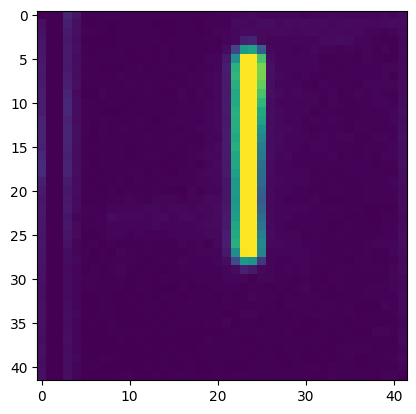

In [57]:
import numpy as np
import matplotlib.pyplot as plt

image= np.loadtxt("image_real.txt", dtype=int)


# image = image.reshape(1, 28, 28)

# image_resize = np.zeros((image.shape[0], 42, 42), dtype=np.uint8)
# for i in range(image_resize.shape[0]):
#     x_train_resized[i] = cv2.resize(x_train[i], (42, 42))

image.resize((42, 42))
plt.imshow(image)


for i in range(image.shape[0]):
    image[i] = image[i] / 2

image.resize((42, 42))

print(image.shape)
max_v = np.max(image)
print(max_v)


def convert_to_binary(image):
    # binary_images = []

    # for img in images:
    #     
    binary_img = []

    for pixel_value in np.nditer(image):
        binary_str = format(pixel_value, '08b')
        binary_img.append(binary_str)

    return binary_image
    
binary_image = convert_to_binary(image)

print("Shape of binary image:",len(binary_image))
#print(binary_image[0])


def binary_to_float(binary_str):
    weights = [-8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625]
    
    result = 0
    
    for i, bit in enumerate(binary_str):
        result += int(bit) * weights[i]
    
    return result


def convert_to_float(binary_image):

    float_img = []

    for binary_str in binary_image:
        for bstr in binary_str:
            print(bstr)
            float_value = binary_to_float(bstr)
            float_img.append(float_value)
        
    float_img = np.array(float_img).reshape((42, 42))

    return float_img

    
new_image = convert_to_float(binary_image)
new_image.resize(1,1764)
np.savetxt("image_converted.txt", new_image, fmt='%.6f',delimiter=',')

### Code for the Accuracy of Floating point for the whole test dataset(For Debugging), it will take time

In [5]:
import matplotlib.pyplot as plt

total_correct = 0
total_errors = 0
model = load_model('model_weights_FP.h5')
weights_and_biases = np.loadtxt("model_weights_FP.txt")

weights_shape = (3, 3, 1, 4)  # Assuming kernel size of (3, 3) and 4 filters
weights2_shape = (3, 3, 4, 4)
weights3_shape = (324, 10)

weights = weights_and_biases[0:36].reshape(weights_shape)  # weights
biases = weights_and_biases[36:40]  # biases

weights2 = weights_and_biases[40:184].reshape(weights2_shape)
biases2 = weights_and_biases[184:188]

weights3 = weights_and_biases[188:3428].reshape(weights3_shape)
biases3 = weights_and_biases[3428:3438]

#Model Below
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=(42, 42, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))

model.layers[0].set_weights([weights, biases])
model.layers[2].set_weights([weights2, biases2])
model.layers[5].set_weights([weights3, biases3])

for val in range(len(FP_x_test_resized)):
  img_array = FP_x_test_resized[val].flatten()

  np.savetxt("mnist_image_1.txt", img_array , fmt='%.6f', newline='\n' )


  img_array = np.loadtxt('mnist_image_1.txt')
  img_array = img_array.reshape((1, 42, 42, 1))  # Reshape to (batch_size, height, width, channels)

  conv1_output = model.predict(img_array)

  # Save the dense layer output
  with open('Python_prog_out_Dense.txt', 'w') as file:
      file.write("Channel 1: \n")
      for i in range(conv1_output.shape[1]):
          file.write("%0.2f\n" % (conv1_output[0, i]))


  #################################################################
  output_values = []

  # Read the file
  with open('Python_prog_out_Dense.txt', 'r') as file:
      lines = file.readlines()
      for line in lines[1:]:
          output_values.append(float(line.strip()))  

  predicted_class = np.argmax(output_values)

  actual_class = np.argmax(y_test[val])

  if predicted_class == actual_class:
    total_correct += 1
  else:
    total_errors += 1

print(f"Total Correct Predictions: {total_correct}")
print(f"Total Errors: {total_errors}")

print(f"Accuracy = {(total_correct/(total_correct+total_errors))*100}")


c:\Users\Rishit Thakkar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

### Below code takes in all the test set, converts into binary and saves all as arrays in a text file(Compatible with C)

In [4]:
import numpy as np

def write_arrays_to_text(data_filename, output_filename, image_index):
    with open(data_filename, "r") as data_file, open(output_filename, "a") as output_file:
        image_data = data_file.read().strip()  # Read and strip extra newlines
        output_file.write(f"int8_t image_{image_index+1} [] = {{{{{image_data}}}}};\n")

def converter(num):
    int_part = int(num)
    frac_part = abs(num - int_part)

    if num < 0:
        binary_string = "1"
        num += 8  
    else:
        binary_string = "0"

    for power in [4, 2, 1]:
        if num >= power:
            binary_string += "1"
            num -= power
        else:
            binary_string += "0"

    for place_value in [0.5, 0.25, 0.125, 0.0625]:
        if frac_part >= place_value:
            binary_string += "1"
            frac_part -= place_value
        else:
            binary_string += "0"

    return "0b" + binary_string

def convert_from_file(filename, output_filename):
    with open(filename, "r") as input_file, open(output_filename, "w") as output_file:
        for line in input_file:
            num = float(line.strip())
            binary_string = converter(num)
            output_file.write(binary_string + "\n")

# File to store class labels
labels_filename = "mnist_labels.txt"
with open(labels_filename, 'w') as labels_file:
    for val in range(len(FP_x_test_resized)):
        img_array = FP_x_test_resized[val].flatten()

        np.savetxt("mnist_image_1.txt", img_array, fmt='%.6f', newline='\n')

        filename = "mnist_image_1.txt"
        output_filename = "binary_" + filename
        convert_from_file(filename, output_filename)

        # Read binary output, format as comma-separated string
        with open(output_filename, 'r') as file:
            lines = file.readlines()
        array_str = ','.join(line.strip() for line in lines)

        # Write formatted binary data to a temporary file
        temp_data_filename = "temp_binary_mnist_image_1.txt"
        with open(temp_data_filename, 'w') as file:
            file.write(array_str)

        # Append formatted data to the main output file
        write_arrays_to_text(temp_data_filename, "image_data.txt", val)

        # Write the class label to the labels file
        class_label = np.argmax(y_test[val])  # Assuming y_test is one-hot encoded
        labels_file.write(f"{class_label}\n")


### Below code takes in all the test set, and saves all as arrays as float values in a text file(Compatible with C)

In [36]:
import numpy as np

def write_arrays_to_text(data_filename, output_filename, image_index):
    with open(data_filename, "r") as data_file, open(output_filename, "a") as output_file:
        image_data = data_file.read().strip()  # Read and strip extra newlines
        output_file.write(f"float fl_image_{image_index+1} [] = {{{{{image_data}}}}};\n")


# File to store class labels
labels_filename = "mnist_labels_FP.txt"
with open(labels_filename, 'w') as labels_file:
    for val in range(len(FP_x_test_resized)):
        img_array = FP_x_test_resized[val].flatten()
        np.savetxt("mnist_image_1.txt", img_array, fmt='%.6f', newline='\n')

        filename = "mnist_image_1.txt"

        # Read binary output, format as comma-separated string
        with open(filename, 'r') as file:
            lines = file.readlines()
        array_str = ','.join(line.strip() for line in lines)

        # Write formatted binary data to a temporary file
        temp_data_filename = "temp_binary_mnist_image_1.txt"
        with open(temp_data_filename, 'w') as file:
            file.write(array_str)

        # Append formatted data to the main output file
        write_arrays_to_text(temp_data_filename, "fl_image_data.txt", val)

        # Write the class label to the labels file
        class_label = np.argmax(y_test[val])  # Assuming y_test is one-hot encoded
        labels_file.write(f"{class_label}\n")


### Below will just generate a file containing float* fl_images[10000] = {fl_image_1, fl_image_2, fl_image_3,........}

In [6]:
def generate_images_array_content(num_images=10000):
    images_list = ', '.join(f'fl_image_{i}' for i in range(1, num_images + 1))
    content = f"float* fl_images[{num_images}] = {{{images_list}}};"
    return content

def write_to_file(filename, content):
    with open(filename, 'w') as file:
        file.write(content)

def main():
    filename = "output.c"  # Set the filename
    content = generate_images_array_content()  # Generate the array content
    write_to_file(filename, content)  # Write the content to the file
    print(f"Content written to {filename} successfully.")

if __name__ == "__main__":
    main()


Content written to output.c successfully.


# Testing with individual Images from the test set

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


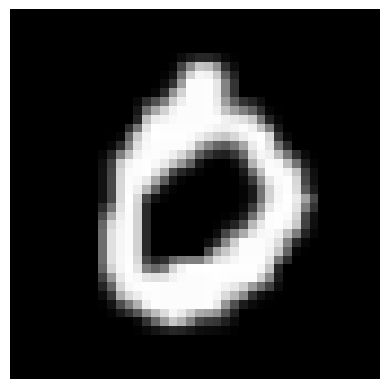

In [12]:
import matplotlib.pyplot as plt
val = 3
img_array = FP_x_test_resized[val].flatten()


print(y_test[val])
np.savetxt("mnist_image_1.txt", img_array , fmt='%.6f', newline='\n' )


img_array = FP_x_test_resized[val].reshape(42, 42)

# Plot the image
plt.imshow(img_array, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()



In [4]:
def converter(num):

  int_part = int(num)
  frac_part = abs(num - int_part)

  if num < 0:
    binary_string = "1"
    num += 8  
  else:
    binary_string = "0"

  for power in [4, 2, 1]:
    if num >= power:
      binary_string += "1"
      num -= power
    else:
      binary_string += "0"

  for place_value in [0.5, 0.25, 0.125, 0.0625]:
    if frac_part >= place_value:
      binary_string += "1"
      frac_part -= place_value
    else:
      binary_string += "0"

  return "0b" + binary_string

def convert_from_file(filename, output_filename):
  with open(filename, "r") as input_file, open(output_filename, "w") as output_file:
    for line in input_file:
      num = float(line.strip())  
      binary_string = converter(num)
      output_file.write(binary_string + "\n")

filename = "mnist_image_1.txt"  
output_filename = "binary_" + filename
convert_from_file(filename, output_filename)

print(f"Converted data from {filename} to binary and saved in {output_filename}")

Converted data from mnist_image_1.txt to binary and saved in binary_mnist_image_1.txt


In [13]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint


model = load_model('model_weights.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(FP_x_test_resized, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9642 - loss: 0.1064
Test Loss: 0.09022897481918335
Test Accuracy: 0.9726999998092651


In [14]:
weights_and_biases = np.loadtxt("model_weights.txt")

weights_shape = (3, 3, 1, 4)  # Assuming kernel size of (3, 3) and 4 filters
weights2_shape = (3, 3, 4, 4)
weights3_shape = (324, 10)

weights = weights_and_biases[0:36].reshape(weights_shape)  # weights
biases = weights_and_biases[36:40]  # biases

weights2 = weights_and_biases[40:184].reshape(weights2_shape)
biases2 = weights_and_biases[184:188]

weights3 = weights_and_biases[188:3428].reshape(weights3_shape)
biases3 = weights_and_biases[3428:3438]

#Model Below
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=(42, 42, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))

model.layers[0].set_weights([weights, biases])
model.layers[2].set_weights([weights2, biases2])
model.layers[5].set_weights([weights3, biases3])


img_array = np.loadtxt('mnist_image_1.txt')
img_array = img_array.reshape((1, 42, 42, 1))  # Reshape to (batch_size, height, width, channels)

conv1_output = model.predict(img_array)

# Save the convolutional layer output
print("Output shape of the Dense layer:", conv1_output.shape)

# Save the dense layer output
with open('Python_prog_out_Dense.txt', 'w') as file:
    file.write("Channel 1: \n")
    for i in range(conv1_output.shape[1]):
        file.write("%0.2f\n" % (conv1_output[0, i]))

print("Dense layer output saved")


#################################################################
output_values = []

# Read the file
with open('Python_prog_out_Dense.txt', 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        output_values.append(float(line.strip()))  

predicted_class = np.argmax(output_values)

actual_class = np.argmax(y_test[val])

print(actual_class)

if predicted_class == actual_class:
  print(f"Prediction is Correct!  Predicted: {predicted_class}, Actual: {actual_class}")
else:
  print(f"Prediction is Incorrect. Predicted: {predicted_class}, Actual: {actual_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Output shape of the Dense layer: (1, 10)
Dense layer output saved
0
Prediction is Correct!  Predicted: 0, Actual: 0


### Scaling the weights from -8 to 8: Better in terms of Accuracy and for Fixed Point Model

In [8]:
import numpy as np
float_values = np.loadtxt("model_weights_FP_rearrange.txt")

max_value = np.max(np.abs(float_values))

scaled_values = (float_values/max_value) * 8

np.savetxt("model_weights_FP_scaled.txt", scaled_values, fmt='%f')

### Convert from 1 column to 1 row

In [1]:
with open('binary_image0_real.txt', 'r') as file:
    lines = file.readlines()

array_str = ','.join(line.strip() for line in lines)

with open('binary_image0_real.txt' , 'w') as file:
    file.write(array_str)

### Convert from 1 row to 1 column

In [7]:
with open('binary_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split(',')

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    for value in values:
        file.write(value.replace("0b", "8'b").strip() + '\n')


3438


### Converting the weights and bias in verilog format with padding of 0s

In [38]:
# convert 1 row into 1 column with verilog format
with open('binary_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split(',')

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    for value in values:
        # file.write(value.replace("0b", "8'b").strip() + '\n')
        file.write(value.replace("0b", '').strip() + '\n')

#########################################
# convert in the 1 row format

with open('verilog_weights_FP_scaled.txt', 'r') as file:
    lines = file.readlines()

array_str = ','.join(line.strip() for line in lines)

with open('verilog_weights_FP_scaled.txt' , 'w') as file:
    file.write(array_str)

##########################################
# padding with 0s
with open('verilog_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split()

# print(len(values))
num_values_needed = 4096 - len(values)

if num_values_needed > 0:
    values.extend(["8'b00000000"] * num_values_needed)

updated_content = ' '.join(values)

# print(len(updated_content))

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    file.write(updated_content)



In [ ]:
# convert 1 row into 1 column with verilog format
with open('test.txt', 'r') as file:
    content = file.read()

values = content.split(',')

with open('test.txt', 'w') as file:
    for value in values:
        file.write(value.replace("0b", "8'b").strip() + '\n')
        # file.write(value.replace("0b", ).strip() + '\n')

#########################################
# convert in the 1 row format

with open('test.txt', 'r') as file:
    lines = file.readlines()

array_str = ','.join(line.strip() for line in lines)

with open('test.txt' , 'w') as file:
    file.write(array_str)

##########################################
# padding with 0s
with open('test.txt', 'r') as file:
    content = file.read()

values = content.split()

# print(len(values))
num_values_needed = 4096 - len(values)

if num_values_needed > 0:
    values.extend(["8'b11111111"] * num_values_needed)

updated_content = ' '.join(values)

# print(len(updated_content))

with open('test.txt', 'w') as file:
    file.write(updated_content)



In [39]:
with open('verilog_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split()
print(len(values))

4096


### In this format: 00 : 00000000; -- memory address : data 01 : 00000001; 02 : 00000010; 03 : 00000011; 04 : 00000100; 05 : 00000101; 06 : 00000110; 07 : 00000111; 08 : 00001000; 09 : 00001001; 0A : 00001010; 0B : 00001011; 0C : 00001100;

In [50]:
# convert 1 row into 1 column with verilog format
with open('binary_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split(',')

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    for value in values:
        # file.write(value.replace("0b", "8'b").strip() + '\n')
        file.write(value.replace("0b", '').strip() + '\n')

#########################################
# convert in the 1 row format

with open('verilog_weights_FP_scaled.txt', 'r') as file:
    lines = file.readlines()

array_str = ' '.join(line.strip() for line in lines)

with open('verilog_weights_FP_scaled.txt' , 'w') as file:
    file.write(array_str)

##########################################
# padding with 0s
with open('verilog_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split()

# print(len(values))
num_values_needed = 4096 - len(values)

if num_values_needed > 0:
    values.extend(['00000000'] * num_values_needed)

updated_content = ' '.join(values)

# print(len(updated_content))

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    file.write(updated_content)


with open('verilog_weights_FP_scaled.txt', 'r') as file:
    content = file.read()

values = content.split()
print(len(values))

###################################################### Adding the address #########################
with open('verilog_weights_FP_scaled.txt', 'r') as file:
    content = file.read().strip()

values = content.split()

values = [value.strip() for value in values if value.strip()]

if len(values) != 4096:
    raise ValueError("The number of values in the file is not 4096")

formatted_values = []
for i, value in enumerate(values):
    address = f'{i:03X}'
    formatted_values.append(f'{address} : {value}')

updated_content = '\n'.join(formatted_values)

with open('verilog_weights_FP_scaled.txt', 'w') as file:
    file.write(updated_content)

################## Adding the ; after every column ################
with open('verilog_weights_FP_scaled.txt', 'r') as file:
    lines = file.readlines()

array_str = '; '.join(line.strip() for line in lines)

with open('verilog_weights_FP_scaled.txt' , 'w') as file:
    file.write(array_str)



4096


### Same thing as above but smaller

In [1]:
# with open('test.txt', 'r') as file:
#     values = file.read().split(',')

# with open('test.txt', 'w') as file:
#     file.write('\n'.join(value.replace('0b', "8'b").strip() for value in values))

# with open('test.txt', 'r') as file:
#     values = file.read().splitlines()

# array_str = ','.join(values)

# # Padding with zeros to reach 4096 values
# num_values_needed = 4096 - len(values)
# if num_values_needed > 0:
#     array_str += ' ' + ' '.join(["8'b11111111"] * num_values_needed)

# with open('test.txt', 'w') as file:
#     file.write(array_str)

# # Verify the length
# with open('test.txt', 'r') as file:
#     values = file.read().split()
# assert len(values) == 4096, "The number of values is not 4096"

# # # Adding the address in front of each value
# # with open('test.txt', 'r') as file:
# #     values = file.read().split()

# # formatted_values = [f'{i:03X} : {value}' for i, value in enumerate(values)]

# # with open('verilog_weights_FP_scaled.txt', 'w') as file:
# #     file.write('\n'.join(formatted_values))

# # # Adding a semicolon after each line
# # with open('verilog_weights_FP_scaled.txt', 'r') as file:
# #     lines = file.readlines()

# # with open('verilog_weights_FP_scaled.txt', 'w') as file:
# #     file.write('; '.join(line.strip() for line in lines))


In [8]:
with open('weights_verilog.txt', 'w')  as file:
    file.write('{')
    for i in range(len(dir)):
        file.write("0'b" + dir[len(dir)-1-i])
        file.write(",")
    file.write('}')
